# 02_exploratory_data_visualization

This notebook loads and plots data from [00_preprocessing.ipynb](00_preprocess.ipynb) and [01_define_extremes.ipynb](01_define_extremes.ipynb).

TODO:

1. Look at distributions of events with different ENSO indices
   - accumulated area over the entire event
   - duration
   - number of events with footprints within the tropics +/- 10º Indian and Pacific only



2. Cluster trajectoreis of objects 
   - Find trajectories based on the centroid with the largest object


In [1]:
import os, sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# get_cpt: https://zenodo.org/record/3703160#.YRFm3xNKhqs
cptpath = r'/burg/home/hs3277/getcpt-master'
sys.path.append(cptpath)
import get_cpt 

import warnings
warnings.filterwarnings('ignore')

#### Load datasets

In [2]:
file_path_list = ('/burg/abernathey/users/hillary/oisst_v21/preprocessed_OISSTv21.nc',
                  '/burg/abernathey/users/hillary/oisst_v21/positive_extremes_OISSTv21.nc',
                  '/burg/abernathey/users/hillary/oisst_v21/ENSO_models_OISSTv21.nc',
                 )
ds = xr.open_mfdataset(file_path_list)
ds

<xarray.Dataset>
Dimensions:                     (time: 478, lat: 720, lon: 1440, month: 12)
Coordinates:
  * time                        (time) datetime64[ns] 1981-09-01 ... 2021-06-01
  * lat                         (lat) float32 -89.88 -89.62 ... 89.62 89.88
  * lon                         (lon) float32 0.125 0.375 0.625 ... 359.6 359.9
  * month                       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables: (12/21)
    Nino3                       (time) float64 dask.array<chunksize=(478,), meta=np.ndarray>
    Nino3_4                     (time) float64 dask.array<chunksize=(478,), meta=np.ndarray>
    Nino4                       (time) float64 dask.array<chunksize=(478,), meta=np.ndarray>
    ssta_Nino3                  (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    ssta_Nino3_4                (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    ssta_Nino4                  (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    ...                          ...
    ssta_stn_notrend            (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    prct_notrend                (month, lat, lon) float64 dask.array<chunksize=(12, 720, 1440), meta=np.ndarray>
    mhw_ssta_notrend            (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    mhw_ssta_notrend_noNino3    (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    mhw_ssta_notrend_noNino3_4  (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    mhw_ssta_notrend_noNino4    (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
Attributes:
    description:  preprocessed monthly averaged and detrended OISST v2.1 data

### Visualize the climatology, standard deviation, seasonal amplitude, and trend. 

In [4]:
# Standard deviation of detrended SSTA 
stdev_global = ds.ssta_notrend.std('time')
stdev_global.load();

In [5]:
# Seasonal cycle amplitude
S = ds.seas + ds['mean']
seas_amp = S.max('time') - S.min('time')

In [6]:
# Trend 
T = ds.trend + ds['mean']
T = T.sel(time=slice('1990-01-01','2020-12-01')) # trend over 30-years
trend_slope = T[-1,:,:]-T[0,:,:]

In [ ]:
# # Uncomment to create a mask for poleward regions between 70ºS and 65ºN

# stdev_global = stdev_global.sel(lat=slice(-70,65))
# mean_sst = ds_oisst['mean'][0,:,:].sel(lat=slice(-70,65))
# seas_amp = seas_amp.sel(lat=slice(-70,65))
# T = T.sel(lat=slice(-70,65))

# # Create a mask over the poles
# blobs_masked = ds_oisst.ssta_notrend.where((ds_oisst.lat < 65) & (ds_oisst.lat > -70), drop=False, other=9999)
# mask = blobs_masked.where(blobs_masked == 9999, other=np.nan, drop=False)

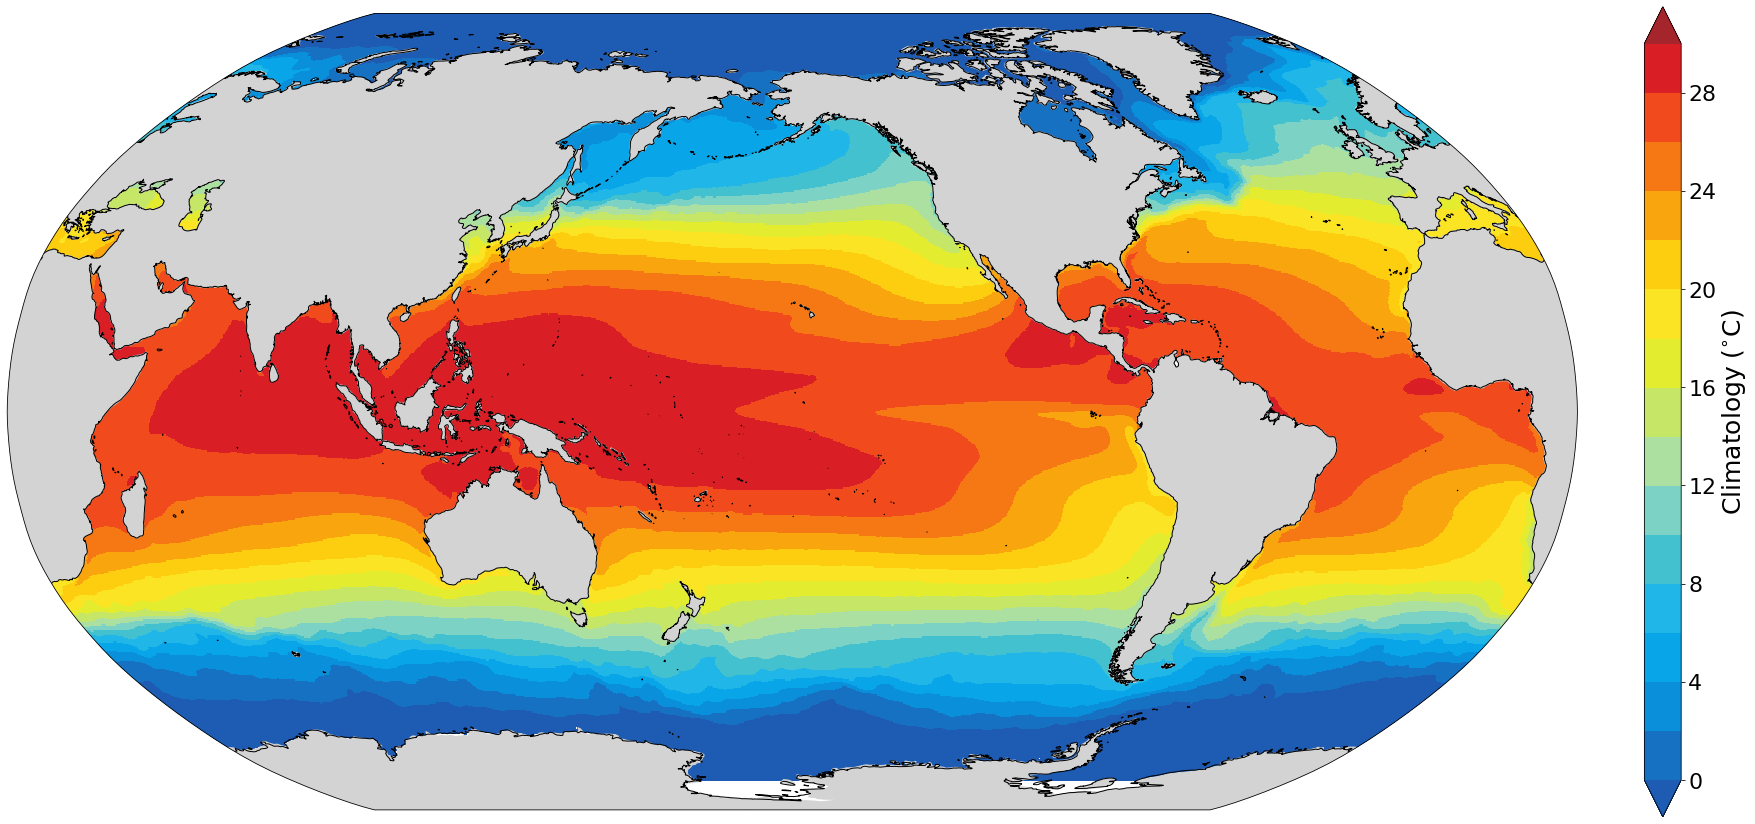

In [10]:
# Make figure 
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
fig = plt.figure(figsize=(30,15)) 


# (a) Climatology
ax = plt.subplot(111, projection=ccrs.Robinson(central_longitude=200))
ax.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1) 
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.coastlines(resolution='50m', color='black', linewidth=1)
cont = ds['mean'].isel(time=0).plot.pcolormesh(vmin=0, vmax=30, levels=np.arange(0,32,2),
                                                     cmap=get_cpt.get_cmap('/burg/home/hs3277/getcpt-master/cpt/temperature.cpt'), 
                                                     extend='both',
                                                     transform=ccrs.PlateCarree(), zorder=0,
                                                     add_labels=False, add_colorbar=False,
                                                    )
cbar = plt.colorbar(cont, fraction=0.022, pad=0.04)
cbar.set_label(r"Climatology ($\rm^{\circ}C$)", fontsize=25)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.tick_params(which='major', width=1.3, length=7)
ax.tick_params(which='minor', width=1, length=4)
# plt.contourf(mask.lon, mask.lat, mask[0,:,:], colors='none', hatches=['///','///'],transform=ccrs.PlateCarree())
ax.set_global()
# plt.text(0.1,1.05, '(a)', size=32, horizontalalignment='right', transform=ax.transAxes)
fig.savefig('/burg/home/hs3277/marine-heatwaves/figs/SST_climatology.png', bbox_inches='tight', format='png', dpi=300)



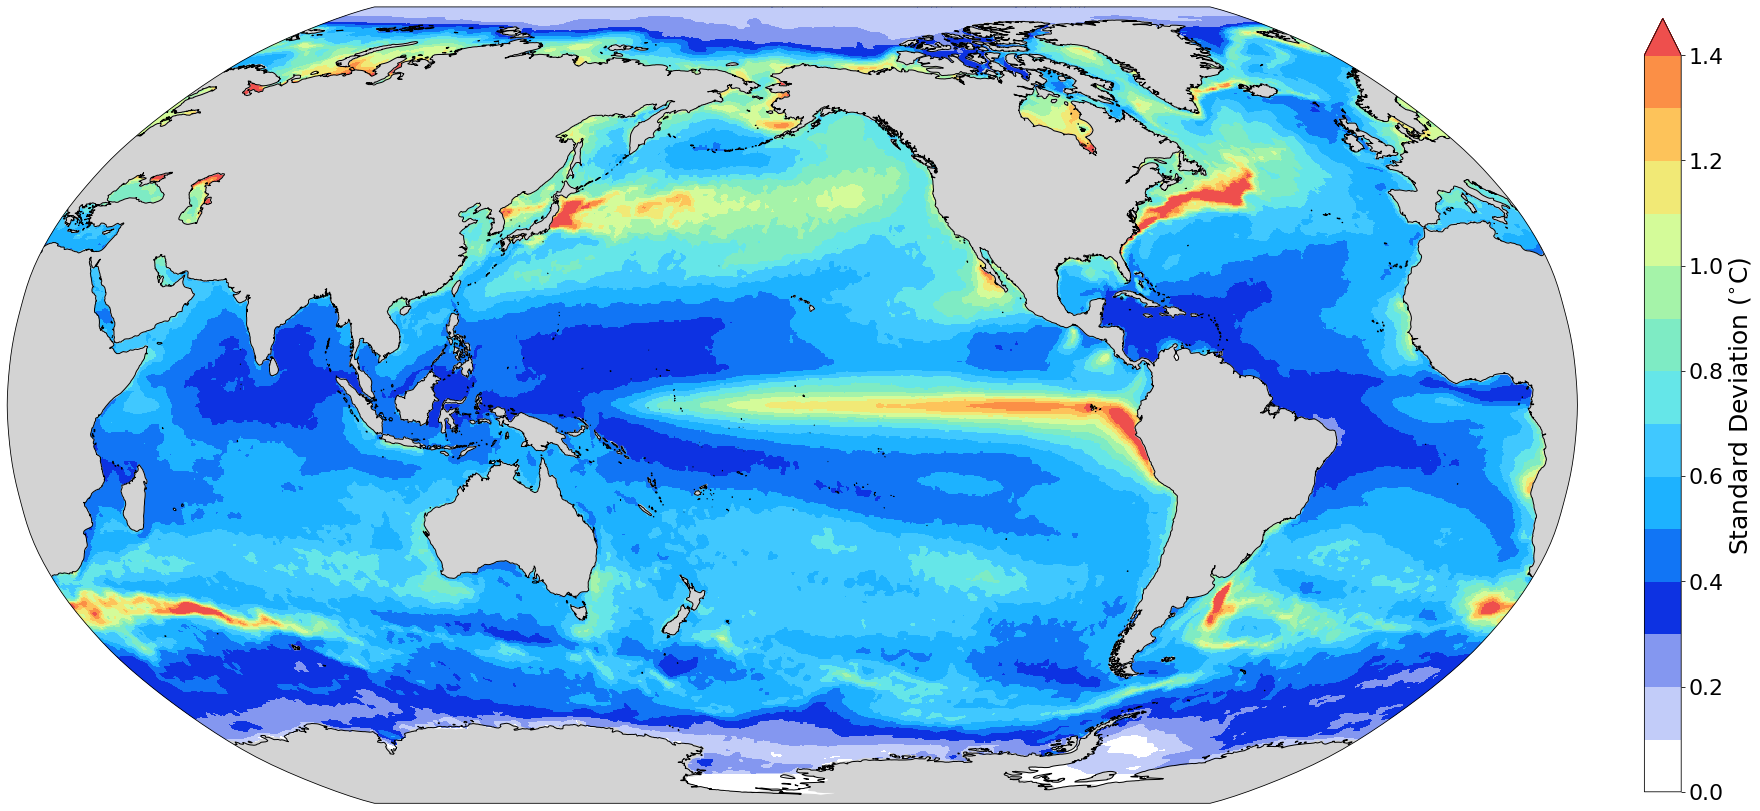

In [11]:
# Make figure 
fig = plt.figure(figsize=(30,15)) 

# (b) Standard Deviation
ax = plt.subplot(111, projection=ccrs.Robinson(central_longitude=200))
ax.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1) 
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.coastlines(resolution='50m', color='black', linewidth=1)
cont = stdev_global.plot.pcolormesh(vmin=0, vmax=1.4, levels=np.arange(0,1.5,.1),
                                    cmap= get_cpt.get_cmap('/burg/home/hs3277/getcpt-master/cpt/seminf-haxby.cpt'), 
                                    extend='max', transform=ccrs.PlateCarree(), 
                                    zorder=0, add_labels=False, add_colorbar=False,
                                   )
cbar = plt.colorbar(cont, fraction=0.022, pad=0.04)
cbar.set_label(r"Standard Deviation ($\rm^{\circ}C$)", fontsize=25)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.tick_params(which='major', width=1.3, length=7)
ax.tick_params(which='minor', width=1, length=4)
# plt.contourf(mask.lon, mask.lat, mask[0,:,:], colors='none', hatches=['///','///'],transform=ccrs.PlateCarree())
ax.set_global()
# plt.text(0.1,1.05, '(b)', size=32, horizontalalignment='right', transform=ax.transAxes)
fig.savefig('/burg/home/hs3277/marine-heatwaves/figs/SST_stdev.png', bbox_inches='tight', format='png', dpi=300)


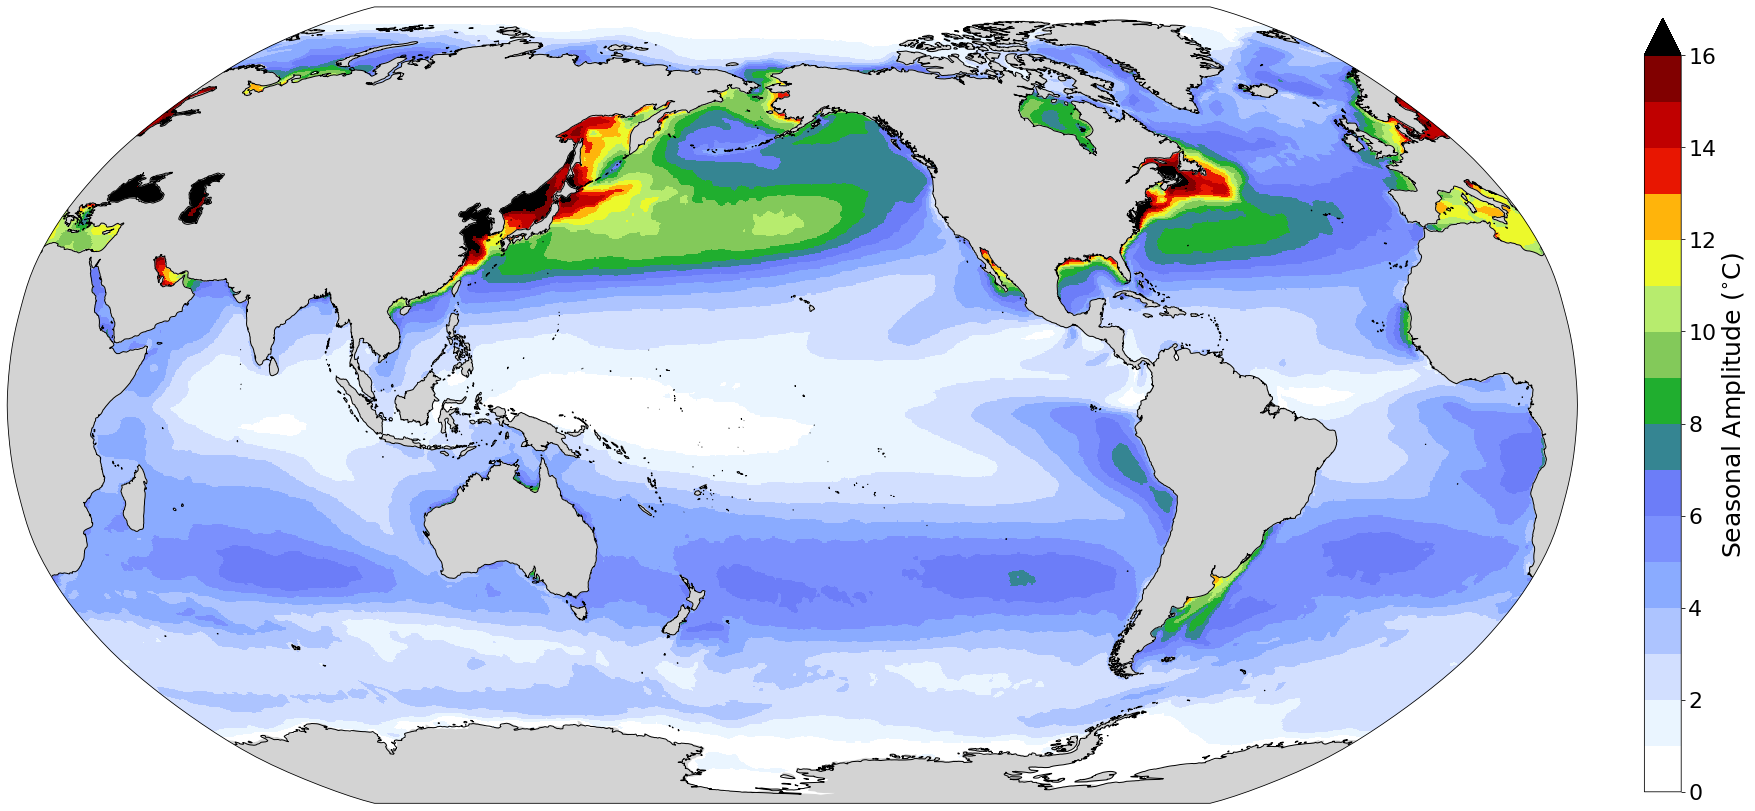

In [12]:
# Make figure 
fig = plt.figure(figsize=(30,15)) 

# (c) Seasonal Amplitude
ax = plt.subplot(111, projection=ccrs.Robinson(central_longitude=200))
ax.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1) 
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.coastlines(resolution='50m', color='black', linewidth=1)
cont = seas_amp.plot.pcolormesh(vmin=0, vmax=20, levels=np.arange(0,17,1),
                                cmap= get_cpt.get_cmap('/burg/home/hs3277/getcpt-master/cpt/precip2_17lev.cpt'), 
                                extend='max', transform=ccrs.PlateCarree(), 
                                zorder=0, add_labels=False, add_colorbar=False,
                               )
cbar = plt.colorbar(cont, fraction=0.022, pad=0.04)
cbar.set_label(r"Seasonal Amplitude ($\rm^{\circ}C$)", fontsize=25)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.tick_params(which='major', width=1.3, length=7)
ax.tick_params(which='minor', width=1, length=4)
# plt.contourf(mask.lon, mask.lat, mask[0,:,:], colors='none', hatches=['///','///'],transform=ccrs.PlateCarree())
ax.set_global()
# plt.text(0.1,1.05, '(c)', size=32, horizontalalignment='right', transform=ax.transAxes)
fig.savefig('/burg/home/hs3277/marine-heatwaves/figs/SST_seas_amp.png', bbox_inches='tight', format='png', dpi=300)


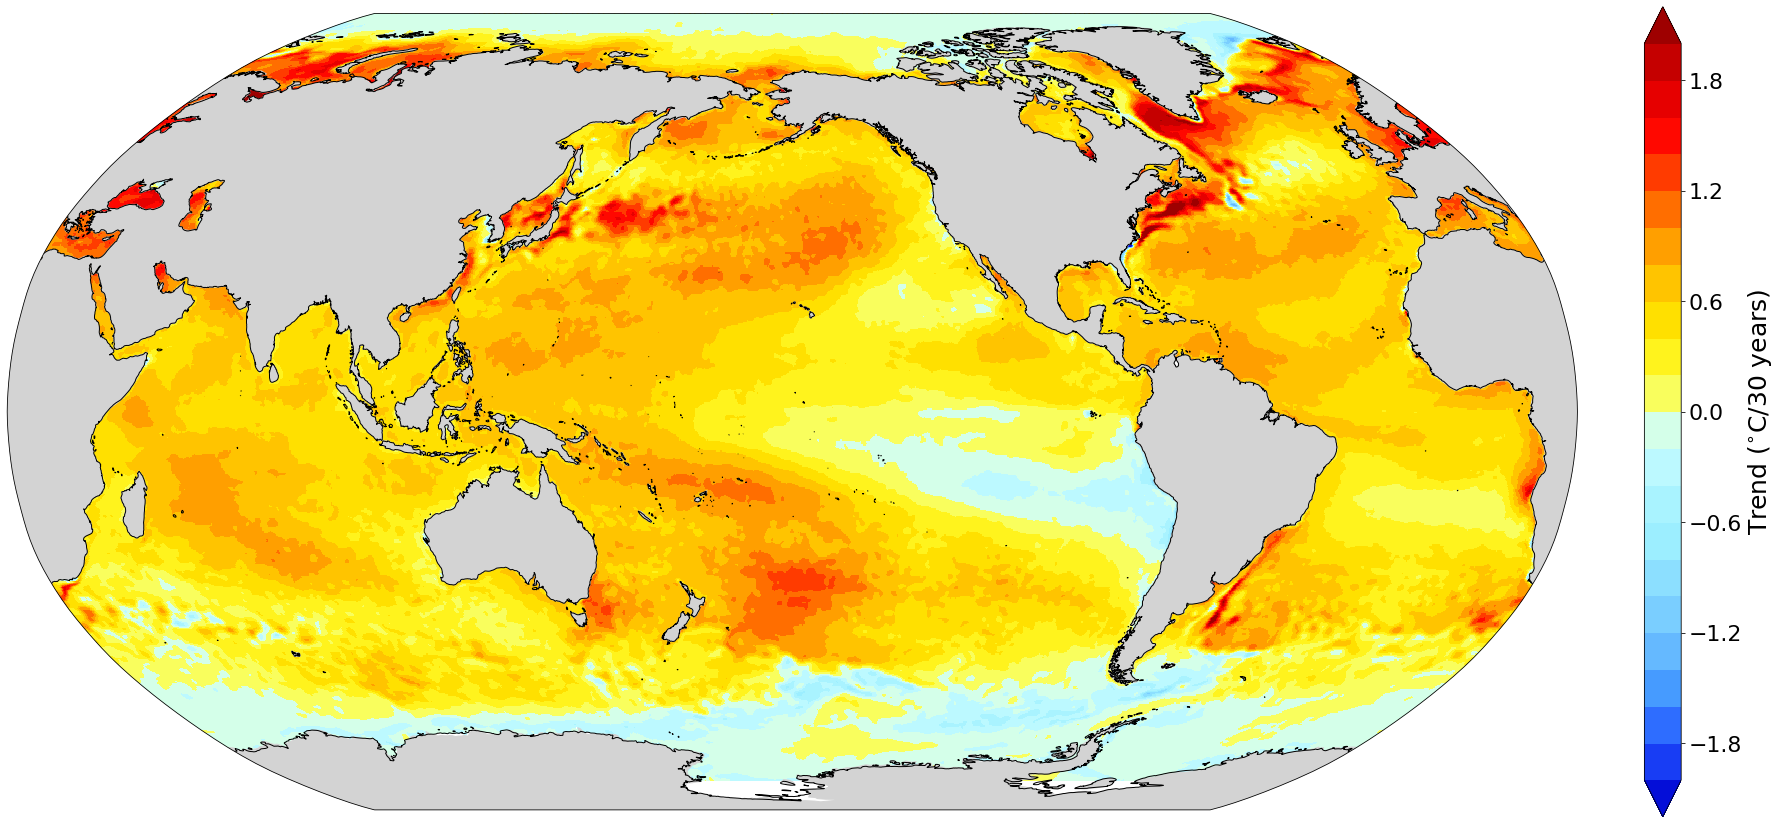

In [15]:
# Make figure 
fig = plt.figure(figsize=(30,15)) 

# (d) Trend
ax = plt.subplot(111, projection=ccrs.Robinson(central_longitude=200))
ax.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1) 
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.coastlines(resolution='50m', color='black', linewidth=1)
cont = trend_slope.plot.pcolormesh(vmin=-2, vmax=2, levels=np.arange(-2,2.2,.2),
                                   cmap= get_cpt.get_cmap('/burg/home/hs3277/getcpt-master/cpt/GMT_panoply.cpt'), 
                                   extend='both', transform=ccrs.PlateCarree(), 
                                   zorder=0, add_labels=False, add_colorbar=False)
cbar = plt.colorbar(cont, fraction=0.022, pad=0.04)
cbar.set_label(r"Trend ($\rm^{\circ}C/30$ years)", fontsize=25)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.tick_params(which='major', width=1.3, length=7)
ax.tick_params(which='minor', width=1, length=4)
# plt.contourf(mask.lon, mask.lat, mask[0,:,:], colors='none', hatches=['///','///'],transform=ccrs.PlateCarree())
ax.set_global()
# plt.text(0.1,1.05, '(d)', size=32, horizontalalignment='right', transform=ax.transAxes);
# fig.savefig('/glade/u/home/scanh/figures/ocetrac_figures/Figure1_oisst_v02r01.png', bbox_inches='tight', format='png', dpi=300)
fig.savefig('/burg/home/hs3277/marine-heatwaves/figs/SST_trend.png', bbox_inches='tight', format='png', dpi=300)


### Visualize anomaly detection

In [16]:
lon=211.125 
lat=46.625 
point_seas = ds.seas.loc[dict(lon=lon, lat=lat)]
point_mean = ds['mean'].loc[dict(lon=lon, lat=lat)]
point_trend = ds.trend.loc[dict(lon=lon, lat=lat)]

In [17]:
# reconstruct SST
mnsst = point_seas+point_mean+point_trend+ds.ssta_notrend.loc[dict(lon=lon, lat=lat)]

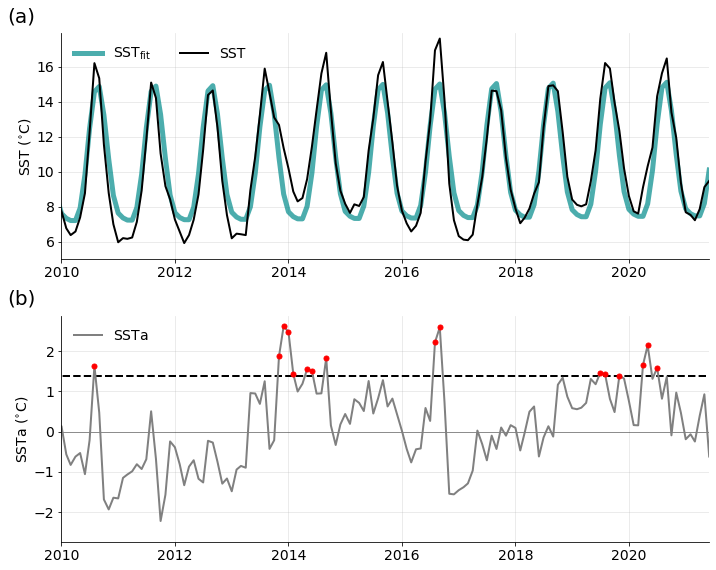

In [21]:
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
fig = plt.figure(figsize=(10,8)) 

ax = plt.subplot(211)
plt.text(-0.04,1.05, '(a)', size=20, horizontalalignment='right', transform=ax.transAxes);
s = plt.plot(point_seas.time, point_seas+point_mean+point_trend, color='darkcyan', lw=5, alpha=0.7, label=r"$\rmSST_{fit}$")
plt.plot(ds.time, mnsst, color='black', lw=2, label='SST')
plt.xlim('2010-01-01',point_seas.time[-1].values);
plt.ylim(5,17.9)
plt.ylabel(r"SST ($\rm ^{\circ}C$)", fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(frameon=False, ncol=2,loc='upper left', fontsize=14)
plt.grid(True, alpha=0.3)

ax = plt.subplot(212)
plt.text(-0.04,1.05, '(b)', size=20, horizontalalignment='right', transform=ax.transAxes);
plt.plot(ds.time, np.zeros(len(ds.time)), color='k', lw=1, alpha=0.4)
plt.plot(ds.time, np.ones(len(ds.time))*ds.prct_notrend.loc[dict(lon=lon, lat=lat)].values, '--', color='k', lw=2)
plt.plot(ds.time, ds.ssta_notrend.loc[dict(lon=lon, lat=lat)], color='gray', lw=2, label=r"$\rmSSTa$")
plt.plot(ds.time, ds.mhw_ssta_notrend.loc[dict(lon=lon, lat=lat)],'r.', ms=10)
plt.xlim('2010-01-01',point_seas.time[-1].values);
plt.ylabel(r"$\rmSSTa$ ($\rm ^{\circ}C$)", fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(frameon=False, ncol=2,loc='upper left', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()

fig.savefig('/burg/home/hs3277/marine-heatwaves/figs/anom_detection_notrend.png', bbox_inches='tight', format='png', dpi=300)



### Effect of 'removing' ENSO 

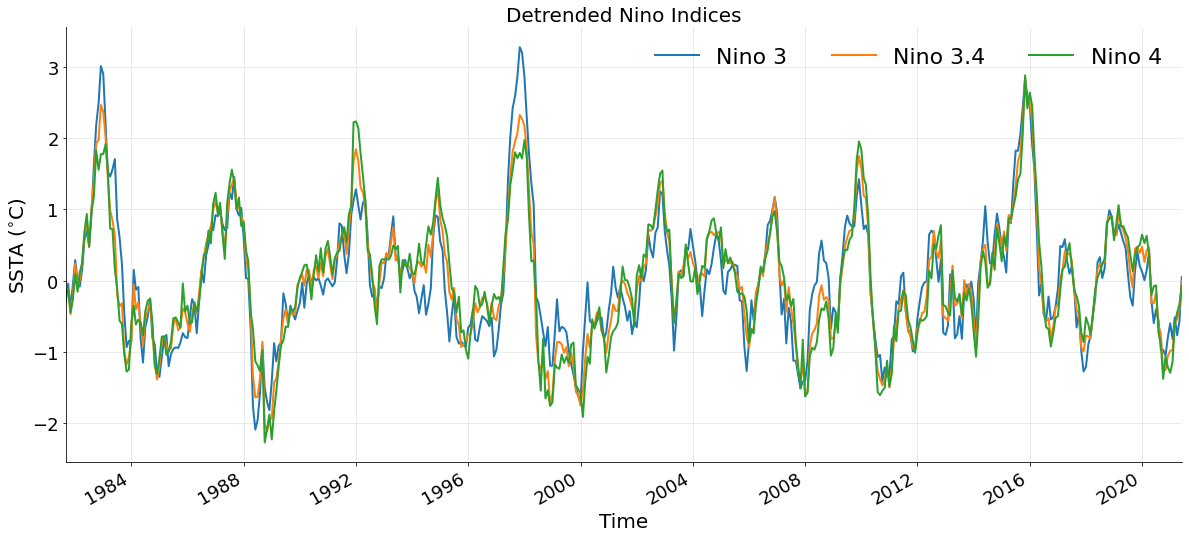

In [25]:
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18)
fig = plt.figure(figsize=(20,8)) 

ax = plt.subplot(111)
ds.Nino3.plot(lw=2, label='Nino 3')
ds.Nino3_4.plot(lw=2, label='Nino 3.4')
ds.Nino4.plot(lw=2, label='Nino 4')
plt.xlim(ds.time[0].values, ds.time[-1].values);
plt.ylabel(r"SSTA ($\rm ^{\circ}C$)", fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.title('Detrended Nino Indices', fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(frameon=False, ncol=3,loc='upper right', fontsize=22)
plt.grid(True, alpha=0.3)
fig.savefig('/burg/home/hs3277/marine-heatwaves/figs/Nino_indices.png', bbox_inches='tight', format='png', dpi=300)


In [ ]:
# Weights for global mean
dlon = np.cos(ds.lat * np.pi/180) *111e3
dlat = 111e3 * xr.ones_like(ds.lon)
cell_area = dlon * dlat

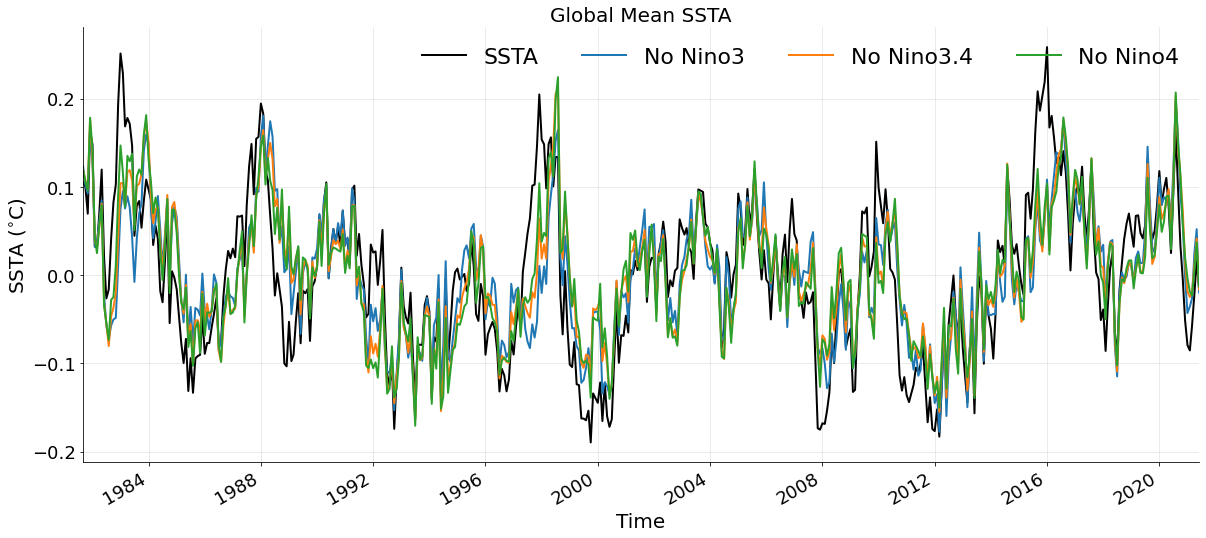

In [32]:
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18)
fig = plt.figure(figsize=(20,8)) 

ax = plt.subplot(111)
ds.ssta_notrend.weighted(cell_area).mean(('lat','lon')).plot(color='k', lw=2, label='SSTA')
ds.ssta_notrend_noNino3.weighted(cell_area).mean(('lat','lon')).plot(lw=2, label='No Nino3')
ds.ssta_notrend_noNino3_4.weighted(cell_area).mean(('lat','lon')).plot(lw=2, label='No Nino3.4')
ds.ssta_notrend_noNino4.weighted(cell_area).mean(('lat','lon')).plot(lw=2, label='No Nino4')
plt.xlim(ds.time[0].values, ds.time[-1].values);
plt.ylabel(r"SSTA ($\rm ^{\circ}C$)", fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.title('Global Mean SSTA', fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(frameon=False, ncol=4,loc='upper right', fontsize=22)
plt.grid(True, alpha=0.3)
fig.savefig('/burg/home/hs3277/marine-heatwaves/figs/SSTA_No_Nino.png', bbox_inches='tight', format='png', dpi=300)



#### Detection of MHW without ENSO

In [34]:
ds

<xarray.Dataset>
Dimensions:                     (time: 478, lat: 720, lon: 1440)
Coordinates:
  * time                        (time) datetime64[ns] 1981-09-01 ... 2021-06-01
  * lat                         (lat) float32 -89.88 -89.62 ... 89.62 89.88
  * lon                         (lon) float32 0.125 0.375 0.625 ... 359.6 359.9
Data variables: (12/21)
    Nino3                       (time) float64 dask.array<chunksize=(478,), meta=np.ndarray>
    Nino3_4                     (time) float64 dask.array<chunksize=(478,), meta=np.ndarray>
    Nino4                       (time) float64 dask.array<chunksize=(478,), meta=np.ndarray>
    ssta_Nino3                  (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    ssta_Nino3_4                (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    ssta_Nino4                  (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    ...                          ...
    ssta_stn_notrend            (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    prct_notrend                (lat, lon) float64 dask.array<chunksize=(720, 1440), meta=np.ndarray>
    mhw_ssta_notrend            (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    mhw_ssta_notrend_noNino3    (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    mhw_ssta_notrend_noNino3_4  (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    mhw_ssta_notrend_noNino4    (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
Attributes:
    description:  preprocessed monthly averaged and detrended OISST v2.1 data

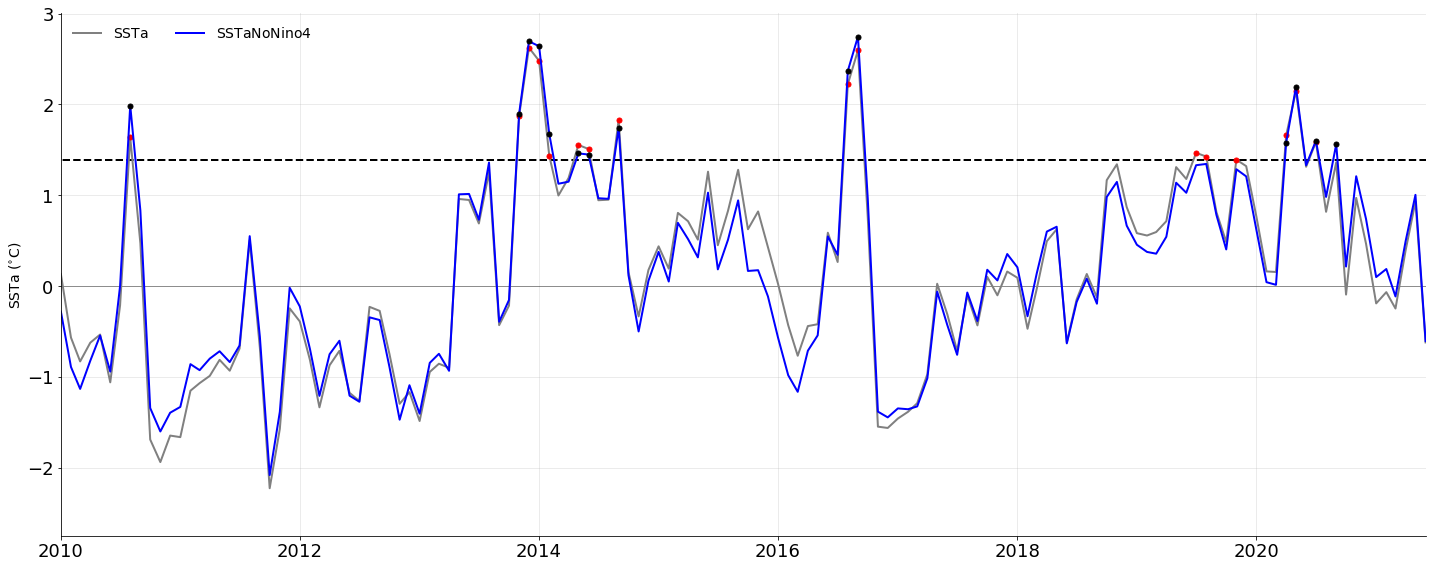

In [38]:
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18)
fig = plt.figure(figsize=(20,8)) 

ax = plt.subplot(111)
plt.plot(ds.time, np.zeros(len(ds.time)), color='k', lw=1, alpha=0.4)
plt.plot(ds.time, np.ones(len(ds.time))*ds.prct_notrend.loc[dict(lon=lon, lat=lat)].values, '--', color='k', lw=2)

plt.plot(ds.time, ds.ssta_notrend.loc[dict(lon=lon, lat=lat)], color='gray', lw=2, label=r"$\rmSSTa$")
plt.plot(ds.time, ds.mhw_ssta_notrend.loc[dict(lon=lon, lat=lat)],'r.', ms=10)

plt.plot(ds.time, ds.ssta_notrend_noNino4.loc[dict(lon=lon, lat=lat)], color='b', lw=2, label=r"$\rmSSTa No Nino4$")
plt.plot(ds.time, ds.mhw_ssta_notrend_noNino4.loc[dict(lon=lon, lat=lat)],'k.', ms=10)

plt.xlim('2010-01-01',point_seas.time[-1].values);
plt.ylabel(r"$\rmSSTa$ ($\rm ^{\circ}C$)", fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(frameon=False, ncol=2,loc='upper left', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()


